# Passing networks' report of England during the EURO

### Prepare the Data

In [90]:
# Import the required libraries
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.colors import to_rgba

# Get all competitions
competitionsDB = pd.DataFrame(sb.competitions())
# Filter only the 2022 women's euro, id is 53
women_euro = competitionsDB[competitionsDB['competition_id'] == 53]

# Get the England's matches, 53 is competition_id and 106 is season_id
games = sb.matches(53, 106)
england_games = games[(games['home_team'] == "England Women's") | (games['away_team'] == "England Women's")]
assert len(england_games) == 6

england_games_ids = [game[1]['match_id'] for game in england_games.iterrows()]

We have the references of all the england's games, let's compute the principal passing networks first

C:\Users\axelg\AppData\Local\Temp\ipykernel_30196\1232197620.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_number_raw['pair'] = pass_number_raw.player + pass_number_raw.pass_recipient
C:\Users\axelg\AppData\Local\Temp\ipykernel_30196\1232197620.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_loc_df['pos_x'] = avg_loc_df.location.apply(lambda x: x[0])
C:\Users\axelg\AppData\Local\Temp\ipykernel_30196\1232197620.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

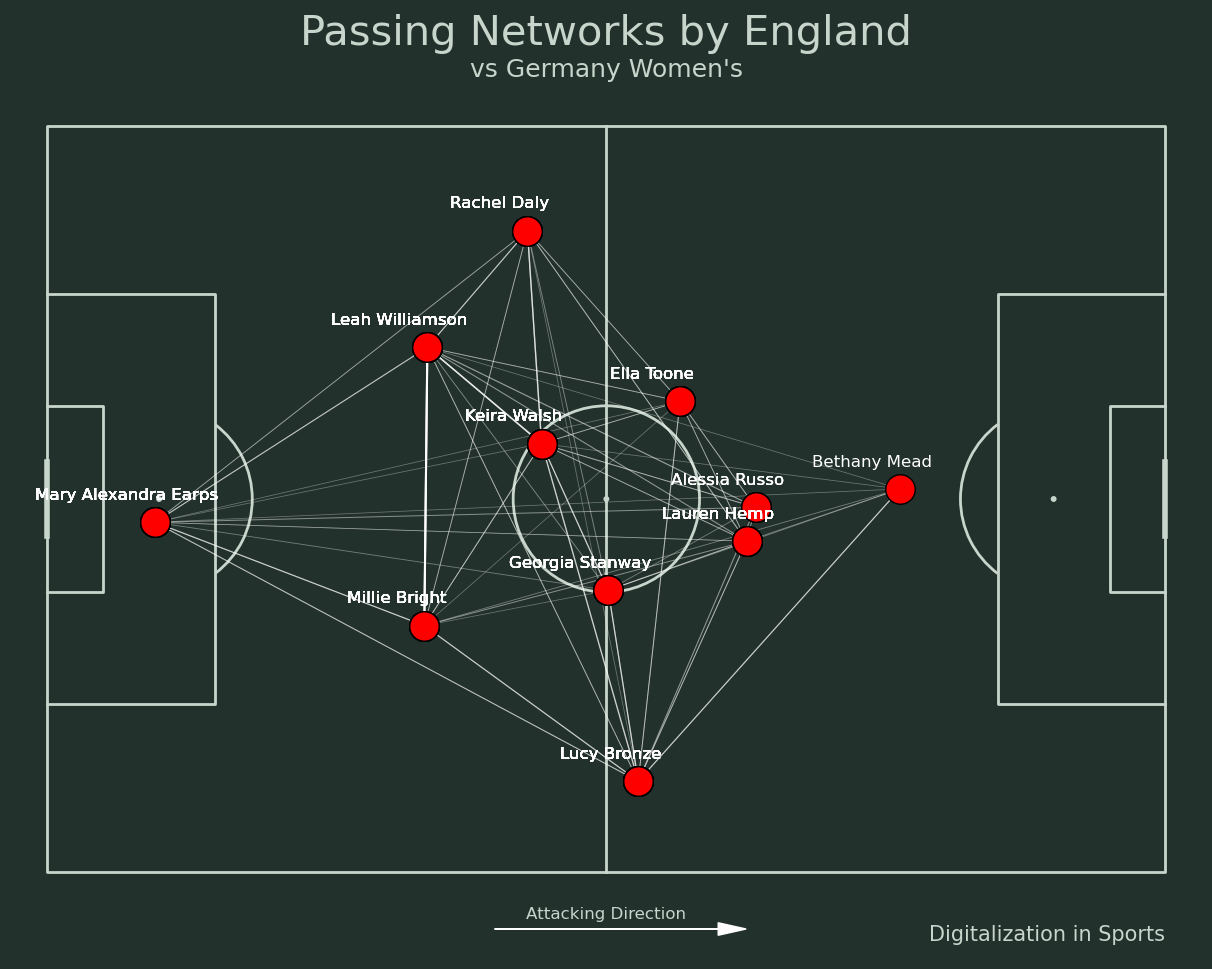

In [91]:
def compute_passing_networks(match_id):
    """"""
    # Source : https://betterprogramming.pub/how-to-visualize-football-passing-networks-using-python-6f6582aa8005

    # Get the events of the game
    game_events = sb.events(match_id)

    # Get the opponent team's name
    opponent_name = [name for name in np.unique(game_events.team.tolist()) if name != "England Women's"][0]

    # Filter the passes events
    pass_raw = game_events[game_events.type == 'Pass']

    pass_number_raw = pass_raw[['timestamp', 'player', 'pass_recipient']]

    # Create identifier to allow counting
    pass_number_raw['pair'] = pass_number_raw.player + pass_number_raw.pass_recipient

    # Count the most paired players
    pass_count = pass_number_raw.groupby(['pair']).count().reset_index()
    pass_count = pass_count[['pair', 'timestamp']]
    pass_count.columns = ['pair', 'number_pass']

    # Get the average's positions of players
    avg_loc_df = pass_raw[['team', 'player', 'location']]

    avg_loc_df['pos_x'] = avg_loc_df.location.apply(lambda x: x[0])
    avg_loc_df['pos_y'] = avg_loc_df.location.apply(lambda x: x[1])
    avg_loc_df = avg_loc_df.drop('location', axis=1)

    # Average player positions
    avg_loc_df = avg_loc_df.groupby(['team','player']).agg({'pos_x': np.mean, 'pos_y': np.mean}).reset_index()

    pass_merge = pass_number_raw.merge(pass_count, on='pair')
    pass_merge = pass_merge[['player', 'pass_recipient', 'number_pass']]
    pass_merge = pass_merge.drop_duplicates()

    avg_loc_df = avg_loc_df[['player', 'pos_x', 'pos_y']]

    # Data processing
    pass_cleaned = pass_merge.merge(avg_loc_df, on='player')
    pass_cleaned.rename({'pos_x': 'pos_x_start', 'pos_y': 'pos_y_start'}, axis='columns', inplace=True)

    pass_cleaned = pass_cleaned.merge(avg_loc_df, left_on='pass_recipient', right_on='player', suffixes=['', '_end'])
    pass_cleaned.rename({'pos_x': 'pos_x_end', 'pos_y': 'pos_y_end'}, axis='columns', inplace=True)

    # Get the players with the most minutes played
    eng_player_df = game_events[game_events.team == "England Women's"].groupby('player').agg({'minute': [min, max]}).reset_index()
    eng_player_df = pd.concat([eng_player_df['player'], eng_player_df['minute']], axis=1)
    eng_player_df['minutes_played'] = eng_player_df['max'] - eng_player_df['min']
    eng_player_df = eng_player_df.sort_values('minutes_played', ascending=False)

    # Filter the best 11
    eng_player_names = eng_player_df.player[:11].tolist()

    pass_eng = pass_cleaned[pass_cleaned.player.isin(eng_player_names)]
    pass_eng = pass_eng[pass_eng.pass_recipient.isin(eng_player_names)]

    # Prepare the plot
    pass_eng['width'] = pass_eng['number_pass'] / pass_eng['number_pass'].max()

    # Plot the graph
    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('white'))
    color = np.tile(color, (len(pass_eng), 1))
    c_transparency = pass_eng.number_pass / pass_eng.number_pass.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
    fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False,
                          title_space=0, grid_height=0.82, endnote_height=0.05)

    fig.set_facecolor("#22312b")
    pass_lines = pitch.lines(pass_eng.pos_x_start, pass_eng.pos_y_start,
                             pass_eng.pos_x_end, pass_eng.pos_y_end, lw=pass_eng.width+0.5,
                             color=color, zorder=1, ax=axs['pitch'])

    pass_nodes = pitch.scatter(pass_eng.pos_x_start, pass_eng.pos_y_start, s=450,
                               color='red', edgecolors='black', linewidth=1, alpha=1, ax=axs['pitch'])

    for index, row in pass_eng.iterrows():
        pitch.annotate(row.player, xy=(row.pos_x_start-3, row.pos_y_start-3), c='white', va='center',
                       ha='center', size=12, ax=axs['pitch'])

    # endnote /title
    axs['endnote'].text(1, 0.5, 'Digitalization in Sports', color='#c7d5cc',
                        va='center', ha='right', fontsize=15)

    axs['endnote'].text(0.5, 0.9, 'Attacking Direction', va='center', ha='center', color='#c7d5cc', fontsize=12)
    axs['endnote'].arrow(0.4, 0.6, 0.2, 0, head_width=0.25, head_length=0.025, ec='w', fc='w')
    axs['endnote'].set_xlim(0, 1)
    axs['endnote'].set_ylim(0, 1)

    axs['title'].text(0.5, 0.7, 'Passing Networks by England', color='#c7d5cc',
                      va='center', ha='center', fontsize=30)
    axs['title'].text(0.5, 0.25, 'vs ' + opponent_name, color='#c7d5cc',
                      va='center', ha='center', fontsize=18)
    plt.savefig('Passing Networks_'+opponent_name+'.png', dpi=300, bbox_inches='tight')
    plt.show()

compute_passing_networks(england_games_ids[0])